# Importing Brevitas networks into FINN with the QONNX interchange format

**Note: Previously it was possible to directly export the FINN-ONNX interchange format from Brevitas to pass to the FINN compiler. This support is deprecated and FINN uses the export to the QONNX format as a front end, internally FINN uses still the FINN-ONNX format.**

In this notebook we'll go through an example of how to import a Brevitas-trained QNN into FINN. The steps will be as follows:

1. Load up the trained PyTorch model
2. Call Brevitas QONNX export and visualize with Netron
3. Import into FINN and converting QONNX to FINN-ONNX

We'll use the following utility functions to print the source code for function calls (`showSrc()`) and to visualize a network using netron (`showInNetron()`) in the Jupyter notebook:

In [1]:
import onnx
from finn.util.visualization import showSrc, showInNetron

## 1. Load up the trained PyTorch model

The FINN Docker image comes with several [example Brevitas networks](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq), and we'll use the LFC-w1a1 model as the example network here. This is a binarized fully connected network trained on the MNIST dataset. Let's start by looking at what the PyTorch network definition looks like:

In [2]:
from brevitas_examples import bnn_pynq
showSrc(bnn_pynq.models.FC)

# Copyright (C) 2023, Advanced Micro Devices, Inc. All rights reserved.
# SPDX-License-Identifier: BSD-3-Clause

import ast
from functools import reduce
from operator import mul

import torch
from torch.nn import BatchNorm1d
from torch.nn import Dropout
from torch.nn import Module
from torch.nn import ModuleList

from brevitas.nn import QuantIdentity
from brevitas.nn import QuantLinear

from .common import CommonActQuant
from .common import CommonWeightQuant
from .tensor_norm import TensorNorm

DROPOUT = 0.2


class FC(Module):

    def __init__(
        self,
        num_classes,
        weight_bit_width,
        act_bit_width,
        in_bit_width,
        in_channels,
        out_features,
        in_features=(28, 28)):
        super(FC, self).__init__()

        self.features = ModuleList()
        self.features.append(QuantIdentity(act_quant=CommonActQuant, bit_width=in_bit_width))
        self.features.append(Dropout(p=DROPOUT))
        in_features = reduce(mul, in_features)
    

We can see that the network topology is constructed using a few helper functions that generate the quantized linear layers and quantized activations. The bitwidth of the layers is actually parametrized in the constructor, so let's instantiate a 1-bit weights and activations version of this network. We also have pretrained weights for this network, which we will load into the model.

In [ ]:
import os
import random
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from finn.util.test import get_test_model
from brevitas.nn import QuantLinear
from brevitas.export import export_qonnx

# ============================================================
# SMART PREGENERATED SYNTHETIC DATASET (AUTO-REGENERATES)
# ============================================================

import os
import torch
from tqdm import tqdm
from torchvision import transforms
import random
from PIL import Image, ImageDraw, ImageFont

CACHE_DIR = "/workspace/font_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

TRAIN_CACHE = os.path.join(CACHE_DIR, "train_data.pt")
TEST_CACHE  = os.path.join(CACHE_DIR, "test_data.pt")

# Same transform as before
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*x - 1)
])

def generate_letter_image(letter, font_path):
    img = Image.new("L", (28, 28), color=255)
    draw = ImageDraw.Draw(img)

    font_size = random.randint(18, 28)
    font = ImageFont.truetype(font_path, font_size)

    bbox = draw.textbbox((0, 0), letter, font=font)
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = (28 - w) // 2
    y = (28 - h) // 2
    draw.text((x, y), letter, fill=0, font=font)

    angle = random.uniform(-10, 10)
    img = img.rotate(angle, expand=False, fillcolor=255)

    return img


def build_or_load_cached_dataset(font_paths, num_train=20000, num_test=5000):
    need_regen = False

    # --- Check cache status ---
    if os.path.exists(TRAIN_CACHE) and os.path.exists(TEST_CACHE):
        print("⚡ Found cached dataset. Validating sizes...")

        train_images, train_labels = torch.load(TRAIN_CACHE)
        test_images, test_labels = torch.load(TEST_CACHE)

        if train_images.shape[0] != num_train or test_images.shape[0] != num_test:
            print("❗ Cached dataset size mismatch. Regenerating...")
            need_regen = True
        else:
            print("✔️ Using cached dataset.")
            return (train_images, train_labels), (test_images, test_labels)
    else:
        print("❗ Cache not found. Generating new dataset...")
        need_regen = True

    if need_regen:
        print("🛠️ Building dataset... (this happens only when sizes change)")

        chars = [chr(ord('A') + i) for i in range(26)]

        def build_split(N):
            images = []
            labels = []
            for _ in tqdm(range(N), desc="Generating images"):
                label = random.randint(0, 25)
                letter = chars[label]
                font = random.choice(font_paths)
                img = generate_letter_image(letter, font)
                img = transform(img)
                images.append(img)
                labels.append(label)
            return torch.stack(images), torch.tensor(labels)

        train_images, train_labels = build_split(num_train)
        test_images, test_labels = build_split(num_test)

        torch.save((train_images, train_labels), TRAIN_CACHE)
        torch.save((test_images, test_labels), TEST_CACHE)

        print("✔️ Dataset cached.")

        return (train_images, train_labels), (test_images, test_labels)

In [ ]:
# ============================
# 1. GOOGLE FONTS DATASET CLASS
# ============================
print("Stage 1: Loading font paths...")
import glob

font_paths = glob.glob("/workspace/fonts/*.ttf")
print("Loaded", len(font_paths), "fonts")


class GoogleFontsLetters(Dataset):
    def __init__(self, font_dir, num_samples=50000, transform=None):
        print("Initializing GoogleFontsLetters dataset...")
        self.font_paths = [os.path.join(font_dir, f)
                           for f in os.listdir(font_dir) if f.endswith(".ttf")]
        assert len(self.font_paths) > 0, "No .ttf font files found in font_dir"

        self.num_samples = num_samples
        self.transform = transform
        self.chars = [chr(ord('A') + i) for i in range(26)]
        print(f"Dataset initialized with {len(self.font_paths)} fonts.")

    def render_letter(self, font_path, letter):
        img = Image.new("L", (28, 28), color=255)
        draw = ImageDraw.Draw(img)

        font_size = random.randint(18, 28)
        font = ImageFont.truetype(font_path, font_size)

        bbox = draw.textbbox((0, 0), letter, font=font)
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]

        x = (28 - w) // 2
        y = (28 - h) // 2

        draw.text((x, y), letter, fill=0, font=font)

        angle = random.uniform(-10, 10)
        img = img.rotate(angle, expand=False, fillcolor=255)

        return img

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        label = random.randint(0, 25)
        letter = self.chars[label]
        font = random.choice(self.font_paths)

        img = self.render_letter(font, letter)

        if self.transform:
            img = self.transform(img)

        return img, label


# ============================
# 2. TRANSFORMS
# ============================
print("Stage 2: Setting up transforms...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*x - 1)
])


# ============================
# 3. LOAD PREGENERATED DATASET
# ============================

print("Stage 3: Loading pregenerated dataset...")

(train_images, train_labels), (test_images, test_labels) = build_or_load_cached_dataset(
    font_paths,
    num_train=50000,
    num_test=5000
)

train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
test_dataset  = torch.utils.data.TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# ============================
# 4. LOAD LFC MODEL (2-BIT VERSION)
# ============================
print("Stage 4: Loading LFC model with 2-bit precision...")
lfc = get_test_model(netname="LFC", wbits=1, abits=2, pretrained=False)

print("Replacing last layer → 26-way output...")
lfc.features[14] = QuantLinear(
    1024, 26,
    bias=False
)

print(lfc)

# ============================
# 5. TRAIN FULL NETWORK
# ============================
print("Stage 5: Starting training...")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(lfc.parameters(), lr=1e-3)

lfc.train()
num_epochs = 40  # keep same or increase if needed

for epoch in range(num_epochs):
    running_loss = 0
    print(f"  → Epoch {epoch+1}/{num_epochs}...")
    for batch_idx, (images, labels) in enumerate(train_loader):
        if batch_idx % 50 == 0:
            print(f"    Processing batch {batch_idx}/{len(train_loader)}")

        images = images.view(images.size(0), -1)

        optimizer.zero_grad()
        outputs = lfc(images)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(lfc.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss/len(train_loader):.4f}")

# ============================
# 6. EVALUATE
# ============================
print("Stage 6: Evaluating the model...")

lfc.eval()
correct, total = 0, 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx % 20 == 0:
            print(f"  Evaluating batch {batch_idx}/{len(test_loader)}")

        images = images.view(images.size(0), -1)
        outputs = lfc(images)
        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")



# ============================
# 7. EXPORT TO QONNX
# ============================
print("Stage 7: Exporting model to QONNX...")

dummy_input = torch.randn(1, 784)
export_qonnx(lfc, dummy_input, "lfc_googlefonts_qonnx.onnx")

print("Export complete: lfc_googlefonts_qonnx.onnx")
print("Script finished successfully.")


Stage 1: Loading font paths...
Loaded 259 fonts
Stage 2: Setting up transforms...
Stage 3: Loading pregenerated dataset...
⚡ Found cached dataset. Validating sizes...
✔️ Using cached dataset.
Stage 4: Loading LFC model with 2-bit precision...
Replacing last layer → 26-way output...
FC(
  (features): ModuleList(
    (0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_cla

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


    Processing batch 50/196
    Processing batch 100/196
    Processing batch 150/196
Epoch 1/40 Loss: 2.1129
  → Epoch 2/40...
    Processing batch 0/196
    Processing batch 50/196
    Processing batch 100/196
    Processing batch 150/196
Epoch 2/40 Loss: 1.6978
  → Epoch 3/40...
    Processing batch 0/196
    Processing batch 50/196
    Processing batch 100/196
    Processing batch 150/196
Epoch 3/40 Loss: 1.5165
  → Epoch 4/40...
    Processing batch 0/196
    Processing batch 50/196
    Processing batch 100/196
    Processing batch 150/196
Epoch 4/40 Loss: 1.3826
  → Epoch 5/40...
    Processing batch 0/196
    Processing batch 50/196
    Processing batch 100/196
    Processing batch 150/196
Epoch 5/40 Loss: 1.2756
  → Epoch 6/40...
    Processing batch 0/196
    Processing batch 50/196
    Processing batch 100/196
    Processing batch 150/196
Epoch 6/40 Loss: 1.1740
  → Epoch 7/40...
    Processing batch 0/196
    Processing batch 50/196
    Processing batch 100/196
    Processin

Test Accuracy: 93.24%


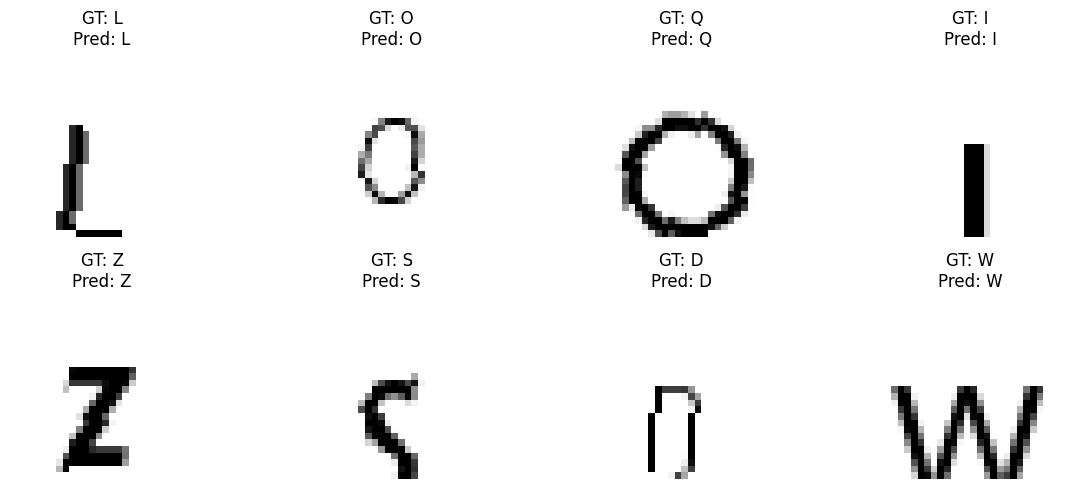

In [4]:
# ============================
# TEST RESULTS AND EXAMPLES
# ============================
import matplotlib.pyplot as plt
import torch

# Ensure model is in evaluation mode
lfc.eval()

correct, total = 0, 0
all_preds = []
all_labels = []

# Collect predictions for the entire test set
with torch.no_grad():
    for images, labels in test_loader:
        images_flat = images.view(images.size(0), -1)
        outputs = lfc(images_flat)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.append(preds)
        all_labels.append(labels)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Concatenate all predictions and labels for sampling
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Show a few example images with predicted vs true labels
num_examples = 8
indices = torch.randperm(len(test_dataset))[:num_examples]

fig, axes = plt.subplots(2, num_examples//2, figsize=(12,5))
axes = axes.flatten()

chars = [chr(ord('A') + i) for i in range(26)]

for i, idx in enumerate(indices):
    img, label = test_dataset[idx]
    pred = all_preds[idx]

    img_np = img.squeeze().cpu().numpy()
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f"GT: {chars[label]}\nPred: {chars[pred]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


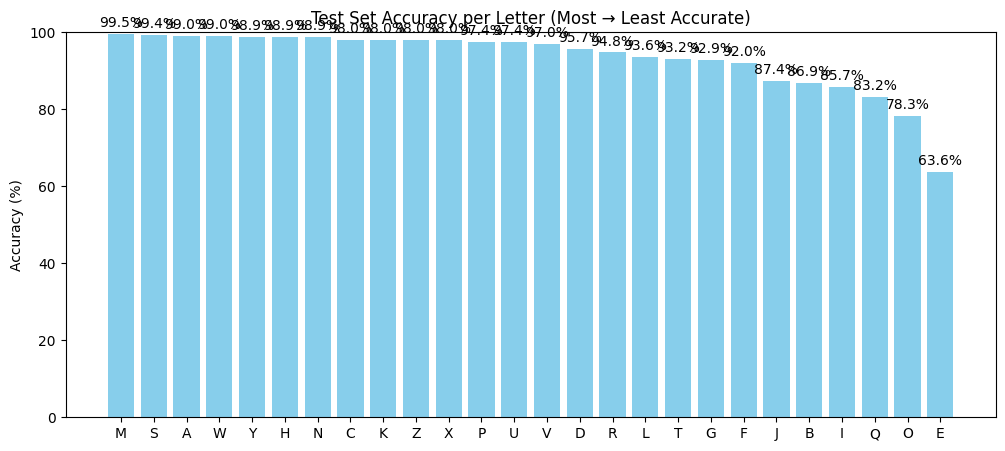

,Letter,Accuracy (%),Num Examples
0,M,99.52,208
1,S,99.39,163
2,A,99.02,205
3,W,98.99,199
4,Y,98.90,182
5,H,98.86,176
6,N,98.86,175
7,C,98.04,204
8,K,98.03,203
9,Z,98.00,200


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lfc.eval()

num_classes = 26
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

# Evaluate test set
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)
        outputs = lfc(images)
        _, preds = torch.max(outputs, 1)
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_total[label] += 1
            if preds[i].item() == label:
                class_correct[label] += 1

# Compute per-class accuracy
class_accuracy = class_correct / class_total * 100
letters = [chr(ord('A') + i) for i in range(num_classes)]

# Sort from most accurate to least accurate
sorted_indices = np.argsort(-class_accuracy)
sorted_letters = [letters[i] for i in sorted_indices]
sorted_accuracy = class_accuracy[sorted_indices]
sorted_total = class_total[sorted_indices]

# Plot bar chart
plt.figure(figsize=(12,5))
bars = plt.bar(sorted_letters, sorted_accuracy, color='skyblue')
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Test Set Accuracy per Letter (Most → Least Accurate)")

# Add accuracy numbers above bars
for bar, acc in zip(bars, sorted_accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{acc:.1f}%", ha='center', va='bottom')

plt.show()

# Display table with letters, accuracy, and number of examples
df = pd.DataFrame({
    "Letter": sorted_letters,
    "Accuracy (%)": np.round(sorted_accuracy, 2),
    "Num Examples": sorted_total.astype(int)
})
df


In [6]:
# ==========================================
# Generate a perfectly centered & straight test set
# ==========================================

import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
import random
import glob

# --------------------------
# 1. Setup
# --------------------------
font_paths = glob.glob("/workspace/fonts/*.ttf")
chars = [chr(ord('A') + i) for i in range(26)]
num_samples_per_letter = 500  # adjust as needed
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*x - 1)  # [-1,1]
])

# --------------------------
# 2. Generate test images
# --------------------------
images, labels = [], []

for label, letter in enumerate(chars):
    for _ in range(num_samples_per_letter):
        font_path = random.choice(font_paths)
        img = Image.new("L", (28,28), color=255)
        draw = ImageDraw.Draw(img)

        # Draw letter perfectly centered
        font_size = 24  # fixed size
        font = ImageFont.truetype(font_path, font_size)
        bbox = draw.textbbox((0,0), letter, font=font)
        w, h = bbox[2]-bbox[0], bbox[3]-bbox[1]
        x, y = (28-w)//2, (28-h)//2
        draw.text((x,y), letter, fill=0, font=font)

        img_tensor = transform(img)
        images.append(img_tensor)
        labels.append(label)

test_images_straight = torch.stack(images)
test_labels_straight = torch.tensor(labels)

# Wrap in DataLoader
test_dataset_straight = torch.utils.data.TensorDataset(test_images_straight, test_labels_straight)
test_loader_straight = torch.utils.data.DataLoader(test_dataset_straight, batch_size=256, shuffle=False)

print("Straight, centered test set ready!")
print("Total samples:", len(test_dataset_straight))


Straight, centered test set ready!
Total samples: 13000


In [7]:
# ==========================================
# Evaluate model on perfectly straight & centered test set
# ==========================================

lfc.eval()  # make sure model is in eval mode

correct_per_letter = [0]*26
total_per_letter = [0]*26
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader_straight:
        images = images.view(images.size(0), -1)  # flatten
        outputs = lfc(images)
        _, preds = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (preds == labels).sum().item()

        for l, p in zip(labels, preds):
            total_per_letter[l.item()] += 1
            if l == p:
                correct_per_letter[l.item()] += 1

# Overall accuracy
overall_acc = 100 * total_correct / total_samples
print(f"Overall straight-centered accuracy: {overall_acc:.2f}%")

# Per-letter accuracy
import pandas as pd
letters = [chr(ord('A')+i) for i in range(26)]
letter_acc = [100*c/t for c,t in zip(correct_per_letter, total_per_letter)]
df = pd.DataFrame({
    "Letter": letters,
    "Correct": correct_per_letter,
    "Total": total_per_letter,
    "Accuracy (%)": [f"{a:.2f}" for a in letter_acc]
}).sort_values("Accuracy (%)", ascending=False)

print("\nPer-letter accuracy (most → least accurate):")
print(df.to_string(index=False))


Overall straight-centered accuracy: 94.56%

Per-letter accuracy (most → least accurate):
Letter  Correct  Total Accuracy (%)
     C      497    500        99.40
     A      495    500        99.00
     W      495    500        99.00
     M      494    500        98.80
     S      493    500        98.60
     P      493    500        98.60
     T      492    500        98.40
     R      492    500        98.40
     X      491    500        98.20
     V      491    500        98.20
     N      491    500        98.20
     K      491    500        98.20
     H      491    500        98.20
     U      490    500        98.00
     Z      490    500        98.00
     G      488    500        97.60
     D      488    500        97.60
     Y      484    500        96.80
     L      483    500        96.60
     B      481    500        96.20
     Q      455    500        91.00
     J      438    500        87.60
     I      431    500        86.20
     F      413    500        82.60
     O     

We have now instantiated our trained PyTorch network. Let's try to run an example MNIST image through the network using PyTorch.

/tmp/ipykernel_6412/1417966531.py:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  input_tensor_pyt = torch.from_numpy(input_tensor_npy).float()


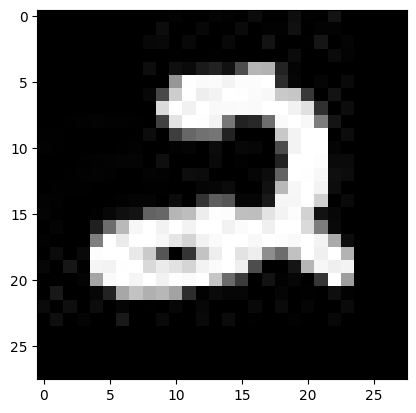

In [8]:
import torch
import matplotlib.pyplot as plt
from pkgutil import get_data
import onnx
import onnx.numpy_helper as nph
raw_i = get_data("qonnx.data", "onnx/mnist-conv/test_data_set_0/input_0.pb")
input_tensor = onnx.load_tensor_from_string(raw_i)
input_tensor_npy = nph.to_array(input_tensor)
input_tensor_pyt = torch.from_numpy(input_tensor_npy).float()
imgplot = plt.imshow(input_tensor_npy.reshape(28,28), cmap='gray')

In [9]:
from torch.nn.functional import softmax
# do forward pass in PyTorch/Brevitas
produced = lfc.forward(input_tensor_pyt).detach()
probabilities = softmax(produced, dim=-1).flatten()
probabilities

tensor([2.0243e-02, 6.3520e-02, 3.9704e-05, 2.7728e-02, 5.0048e-03, 3.5379e-04,
        6.0670e-01, 3.5073e-04, 1.8095e-04, 1.5540e-03, 1.8822e-05, 9.4341e-04,
        5.9040e-04, 9.1916e-04, 2.1109e-04, 6.6257e-05, 2.7429e-02, 6.1619e-02,
        2.7608e-02, 5.0517e-05, 1.5714e-04, 3.0869e-05, 1.5131e-01, 1.6513e-03,
        5.9335e-06, 1.7134e-03])

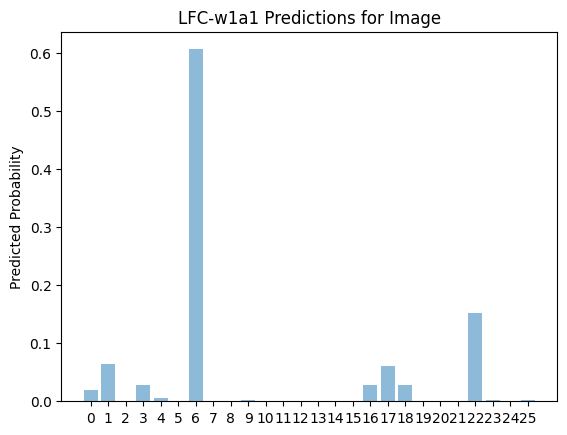

In [10]:
import numpy as np
objects = [str(x) for x in range(26)]
y_pos = np.arange(len(objects))
plt.bar(y_pos, probabilities, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Predicted Probability')
plt.title('LFC-w1a1 Predictions for Image')
plt.show()

## 2. Call Brevitas QONNX export and visualize with Netron

Brevitas comes with built-in QONNX export functionality. This is similar to the regular ONNX export capabilities of PyTorch, with a few differences:

1. Weight and activation quantization is represented as a 'fake-quantization' with Quant and BipolarQuant nodes.
2. Truncation operations as required by average pooling are represented with a Trunc node.

One can read more about how QONNX works and why it was developed here: https://xilinx.github.io/finn//2021/11/03/qonnx-and-finn.html

Additionally QONNX comes with a set of tools for working with the format. These are maintained together with the Fast Machinelearning collaboration as an open-source projet here: https://github.com/fastmachinelearning/qonnx

It's actually quite straightforward to export QONNX from our Brevitas model as follows:

In [11]:
from brevitas.export import export_qonnx
export_onnx_path = "/tmp/LFCW1A1_qonnx.onnx"
input_shape = (1, 1, 28, 28)
export_qonnx(lfc, torch.randn(input_shape), export_onnx_path);

Let's examine what the exported ONNX model looks like. For this, we will use the Netron visualizer:

In [12]:
showInNetron(export_onnx_path,port=8082)

Serving '/tmp/LFCW1A1_qonnx.onnx' at http://0.0.0.0:8082


When running this notebook in the FINN Docker container, you should be able to see an interactive visualization of the imported network above, and click on individual nodes to inspect their parameters. If you look at any of the MatMul nodes, you should be able to see that the weights are all {-1, +1} values.

## 3. Import into FINN and converting QONNX to FINN-ONNX

We will first run a cleanup transformation on the exported QONNX model.

In [13]:
from qonnx.util.cleanup import cleanup

export_onnx_path_cleaned = "/tmp/LFCW1A1-qonnx-clean.onnx"
cleanup(export_onnx_path, out_file=export_onnx_path_cleaned)

In [24]:
showInNetron(export_onnx_path_cleaned,port=8082)

Serving '/tmp/LFCW1A1-qonnx-clean.onnx' at http://0.0.0.0:8082


We will now import this QONNX model into FINN using the ModelWrapper. Here we can immediatley execute the model to verify correctness.

In [15]:
from qonnx.core.modelwrapper import ModelWrapper
import qonnx.core.onnx_exec as oxe
model = ModelWrapper(export_onnx_path_cleaned)
input_dict = {"global_in": nph.to_array(input_tensor)}
output_dict = oxe.execute_onnx(model, input_dict)
produced_qonnx = output_dict[list(output_dict.keys())[0]]

produced_qonnx

array([[ 2.773864  ,  3.9174001 , -3.4602523 ,  3.0884984 ,  1.3764498 ,
        -1.2729964 ,  6.174094  , -1.2816765 , -1.9434953 ,  0.2068747 ,
        -4.2066984 , -0.29220223, -0.7609    , -0.31824106, -1.789432  ,
        -2.9481564 ,  3.077649  ,  3.887022  ,  3.084159  , -3.2193959 ,
        -2.0845385 , -3.7119603 ,  4.785359  ,  0.26763183, -5.361083  ,
         0.30452007]], dtype=float32)

In [16]:
np.isclose(produced, produced_qonnx).all()

True

Using the `QONNXtoFINN` transformation we can convert the model to the FINN internal FINN-ONNX representation. Notably all Quant and BipolarQuant nodes will have disappeared and are converted into MultiThreshold nodes.

In [17]:
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
model = ModelWrapper(export_onnx_path_cleaned)

model = model.transform(ConvertQONNXtoFINN())

export_onnx_path_converted = "/tmp/LFCW1A1-qonnx-converted.onnx"
model.save(export_onnx_path_converted)

In [26]:
showInNetron(export_onnx_path_converted,port=8082)

Serving '/tmp/LFCW1A1-qonnx-converted.onnx' at http://0.0.0.0:8082


And once again we can execute the model with the FINN/QONNX execution engine.

In [19]:
model = ModelWrapper(export_onnx_path_converted)
input_dict = {"global_in": nph.to_array(input_tensor)}
output_dict = oxe.execute_onnx(model, input_dict)
produced_finn = output_dict[list(output_dict.keys())[0]]

produced_finn
produced_qonnx

/home/johncrespo/FPGA/BRH_Tutorials/8_Python_to_FPGA/finn/deps/qonnx/src/qonnx/util/basic.py:296: UserWarning: The values of tensor QR4Rm9 can't be represented with the set datatype annotation (INT2), they will be rounded to match the datatype annotation.
  warnings.warn(
/home/johncrespo/FPGA/BRH_Tutorials/8_Python_to_FPGA/finn/deps/qonnx/src/qonnx/util/basic.py:296: UserWarning: The values of tensor hfJ7Jx can't be represented with the set datatype annotation (INT2), they will be rounded to match the datatype annotation.
  warnings.warn(
/home/johncrespo/FPGA/BRH_Tutorials/8_Python_to_FPGA/finn/deps/qonnx/src/qonnx/util/basic.py:296: UserWarning: The values of tensor gnoKmF can't be represented with the set datatype annotation (INT2), they will be rounded to match the datatype annotation.
  warnings.warn(
/home/johncrespo/FPGA/BRH_Tutorials/8_Python_to_FPGA/finn/deps/qonnx/src/qonnx/util/basic.py:296: UserWarning: The values of tensor RnwctN can't be represented with the set datatype

array([[ 2.773864  ,  3.9174001 , -3.4602523 ,  3.0884984 ,  1.3764498 ,
        -1.2729964 ,  6.174094  , -1.2816765 , -1.9434953 ,  0.2068747 ,
        -4.2066984 , -0.29220223, -0.7609    , -0.31824106, -1.789432  ,
        -2.9481564 ,  3.077649  ,  3.887022  ,  3.084159  , -3.2193959 ,
        -2.0845385 , -3.7119603 ,  4.785359  ,  0.26763183, -5.361083  ,
         0.30452007]], dtype=float32)

In [20]:
np.isclose(produced_qonnx, produced_finn).all()

True

We have succesfully verified that the transformed and cleaned-up FINN graph still produces the same output, and can now use this model for further processing in FINN.